## 프로젝트 시작전

이번에는 NLP기반인 텍스트 감성분석 프로젝트입니다. 처음 들어본 개념과 자주 들었지만 익숙하지 않은 CNN을 가지고 구현을 해야합니다. 다양한 시각화와 하이퍼파라미터 조절를 통해서 잘 해보도록 하겠습니다.

## 텍스트 감성분석(Text Sentimental Analysis)

- 정의: 텍스트에 나타난 주관적 요소인 긍정과 부정을 판별한 후 정량화하는 작업.

- 기본요소: 감성 표현, 대상(개체)

- 단계: 
  
   i) 데이터 수집 단계
   
   :인터넷 매체에서 정보를 수집
   
   ii) 주관성 탐지
   
   : 작성자의 주관이 드러난 부분만 걸러냄.
   
   iii) 주관성의 극성
   
   : 미리 정의된 극성(긍정, 중립, 부정등) 이나 점수로 표현
   
- 수행 방법

   i) 기계학습 기반 접근법
   
   : 패턴을 학습해 예측 모형 구축 후 학습한 데이터와 유사한 특성을 갖는 분석 대상 데이터 적용
   
   : 긍정 혹은 부정으로 분류된 라벨이 있어야함.
   
   ii) 감성사전 기반 접근법
   
   : 충분한 분류된 라벨이 없을 때 사용한다.
   
   : 수집된 데이터를 전처리를 하여 정제를 한 후 미리 구축된 감성사전과 매칭하여 어느 쪽 극성어가 나오는지 정량화하여 분석한다.
   
   : 감성사전은 극성 범주 값과 범주별 특성을 나타내는 감성 점수로 구성. 품질과 직결.
   
   * 단점
   
     - 분석 대상에 따라 단어의 감성 점수가 달라질 가능성에 대응 못함
     
     - 긍부정의 원인이 되는 대상 속성 기반의 감성 분석이 어려움
  
   : 딥러닝 예시
   
    - 기계학습 기법 중 지도학습 기법
    
    - 나이브 베이즈 분류기
    
    - 결정트리 분류기
    
    - kNN 분류기
    
    - 신경망 분류기
    
    - SVM
    
    - 최대 엔트로피 모델
    
    
  iii) 속성 단위 감성 분석
  
  : 정교한 분석 방법으로 대상이 무엇인지, 그 대상이 갖고 있는 특성은 무엇인지 파악.
  

### 평가문항

1.  Classification 태스크를 성공적으로 구현하였다. 3가지 이상의 모델이 성공적으로 시도됨

2. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

- 데이터 준비하기

필요한 라이브러리 import하기 및 데이터 읽기

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터 개수 확인

In [3]:
print(" train data의 개수: {}, test data의 개수: {}".format(len(train_data), len(test_data)))

 train data의 개수: 150000, test data의 개수: 50000


#### 데이터로더 구성

- 데이터의 중복 제거

- NaN 결측치 제거

- 한국어 토크나이저로 토큰화

- 사전 word_to_index구성

- 텍스트 스트링을 사전 인덱스 스트링으로 변환

- X_train, y_train, X_test, y_test, word_to_index 리턴


In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 로더 함수
def load_data(train_data, test_data, num_words=10000):
    
    #train data 전처리 과정으로 중복, 공백 NULL로 변경, 특수문자제거, 결측치 제거
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    
    train_data['document'].replace(" ", np.nan, inplace=True)
    
    
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    
   
    train_data = train_data.dropna(how = 'any') 
    
    # test data전처리 과정으로 중복, 공백Null변경, 특수문자제거,결측치제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    test_data['document'].replace(" ", np.nan, inplace=True)
    
    
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    
    
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 사전 구성
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
   
    # 텍스트 -> 인덱스로 변환 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist] # 사전에 없는 단어 처리
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: The default value of regex will change from True to False in a future version.


위의 데이터 전처리 과정 후 변하게 되는 train data 개수와 test data개수 확인

#### 알아둬야할 기능

- load_data()

: LMS에서도 봤듯이 이 메소드는 전처리 과정뿐만 아니라 저희가 원하는 데이터 처리를 해주고 거기다가 토큰화를 통해서 단어 사전또한 만듭니다. 매우 중요한 메소드 입니다.

In [5]:
print("train data의 개수: {}, test data의 개수: {}".format(len(X_train), len(X_test)))

train data의 개수: 146182, test data의 개수: 49157


마지막으로 사전 딕셔너리 생성을 해야 컴퓨터가 인식을 합니다.

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

필요한 함수 설정

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

텍스트들이 인덱스로 변경이 잘 되었나 확인하기

 ### 텍스트 데이터의 특징
 
 - 단순한 특징: 문장을 받아 긍정이면 1, 부정이면 0을 의미한다
 
 - 텍스트 -> 숫자
 
   i) 문장을 단위로 쪼갠후 딕셔너리 구조({텍스트:인덱스})로 표현.
   
   
   ii) 함수로 만들어서 반복하여 활용.

In [8]:
for k in range(10):
    print(X_train[k])
    print(get_decoded_sentence(X_train[k], index_to_word))
    print('라벨: ', y_train[k])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 192, 2]
재 <UNK>
라벨:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1
[627, 2, 2, 425, 171, 1464, 661, 1592, 665, 46, 2, 4, 61, 2167, 118, 718]
<UNK> <UNK> 세 부터 초등 학교 학년 생 인 <UNK> 영화 ㅋㅋㅋ 별반 개 아까움
라벨:  0
[237, 351, 8, 354, 1909, 51, 11, 780, 5]
긴장감 을 제대로 살려 내 지 못했 다
라벨:  0
[232, 1344, 132, 5, 392, 705, 2, 2, 48, 1434, 269, 93, 233, 23, 882, 24, 321, 608, 501, 475, 546, 5, 3165, 8489, 17, 1386, 1386, 65, 282, 13, 5, 48, 95, 7, 70, 17, 2, 37]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
라벨:  0
[117, 13, 18, 85, 12, 269, 22, 43, 4]
없 는데 재미 있 몇 안 되 영화
라벨:  1
[57, 612

데이터셋 분석 및 문장길이 통일하기

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

문장길이 평균 :  13.718233430088207
문장길이 최대 :  83
문장길이 표준편차 :  11.469848902034261
pad_sequences maxlen :  36
전체 문장의 93.40019146202243%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 36)


padding 이용

In [11]:

x_val = X_train[:10000]
y_val = y_train[:10000]

partial_x_train = X_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(136182, 36)
(136182,)
(10000, 36)
(10000,)


# 모델 구성 (평가문항 1번)

1. LSTM에 대해서 깊이 파보고 싶어서 시리즈물처럼 만들었습니다.

2. 그리고 저걸로는 부족해보여서 LMS에서 나왔던 1-D CNN으로 하겠습니다

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 모델1. LSTM

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 6s 11ms/step - loss: 0.5678 - accuracy: 0.7335 - val_loss: 0.3560 - val_accuracy: 0.8446
Epoch 2/5
266/266 [==============================] - 2s 9ms/step - loss: 0.3459 - accuracy: 0.8523 - val_loss: 0.3499 - val_accuracy: 0.8443
Epoch 3/5
266/266 [==============================] - 2s 9ms/step - loss: 0.3214 - accuracy: 0.8645 - val_loss: 0.3504 - val_accuracy: 0.8450
Epoch 4/5
266/266 [==============================] - 2s 9ms/step - loss: 0.3122 - accuracy: 0.8692 - val_loss: 0.3490 - val_accuracy: 0.8453
Epoch 5/5
266/266 [==============================] - 2s 9ms/step - loss: 0.2992 - accuracy: 0.8747 - val_loss: 0.3500 - val_accuracy: 0.8443


In [14]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4712 - accuracy: 0.8294
[0.4712006151676178, 0.8294037580490112]


epochs = 10 했을 땐 0.84정도 나왔습니다

epochs = 15 했을 땐 0.82정도 나왔습니다.

epochs = 10 다시 했을 땐 0.815정도 나왔습니다.

epochs = 5 했을 땐 0.8443이 나왔습니다.

다양한 epochs로 모델을 학습했고 그 중에서 epochs = 10을 항상 해왔기에 

이젠 조금 새로운 epochs=5로 model 학습을 시켜보도록 하겠습니다.

물론 model학습 시, val set도 함께 학습했습니다.

In [15]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Loss 와 Accurcay를 시각화를 통해서 비교

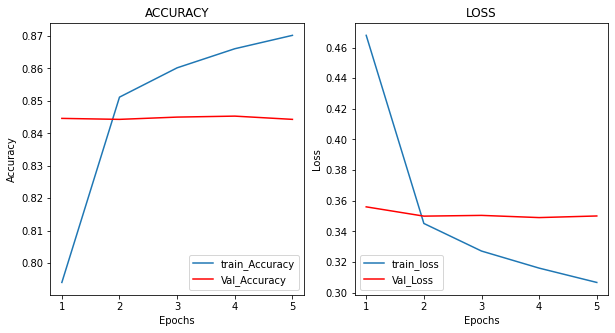

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()



train_loss는 점점 줄어들고 val_loss는 증가하다가 약간감소하는 부분이 있으나 결국 val_loss가 증가하는 추세를 보니 과적합이 되었을 수도 있다고 생각이 듭니다.

혹시 batch_size = 64로 낮추면 어떤 상태로 되는지 궁금하여  시각화를 해보았습니다.

여기서 궁금한 건 batch_size의 위력은 무엇일까요?

즉, batch size를 작게하면 noise가 많아지고 regularization 효과를 줄 수 있습니다. 

너무 작게하면 noise가 너무 커져서 성능에 악영향을 주고, 

적절한 크기의 batch를 선택하면 regularization 효과를 줄 수 있습니다.

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 19s 8ms/step - loss: 0.3080 - accuracy: 0.8687 - val_loss: 0.3470 - val_accuracy: 0.8481
Epoch 2/5
2128/2128 [==============================] - 17s 8ms/step - loss: 0.2893 - accuracy: 0.8775 - val_loss: 0.3482 - val_accuracy: 0.8481
Epoch 3/5
2128/2128 [==============================] - 17s 8ms/step - loss: 0.2613 - accuracy: 0.8917 - val_loss: 0.3547 - val_accuracy: 0.8467
Epoch 4/5
2128/2128 [==============================] - 17s 8ms/step - loss: 0.2344 - accuracy: 0.9023 - val_loss: 0.3608 - val_accuracy: 0.8502
Epoch 5/5
2128/2128 [==============================] - 17s 8ms/step - loss: 0.2178 - accuracy: 0.9112 - val_loss: 0.3851 - val_accuracy: 0.8480


In [18]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6700 - accuracy: 0.5430
[0.6700470447540283, 0.5430152416229248]


In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


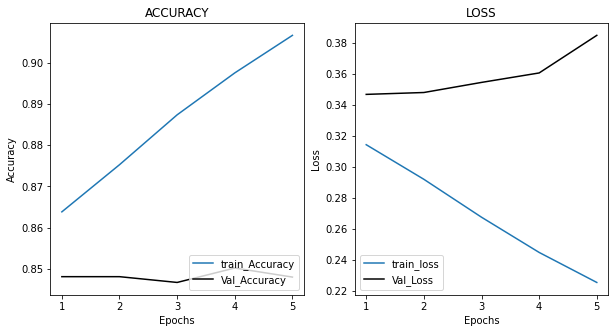

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'black', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'black', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 모델2. Bidirectional LSTM

: 기존 LSTM은 순방향이었지만 역방향을 추가한 이 LSTM은 기존의 것보다 성능이 좋아 자주 쓰이고 있는 알고리즘입니다.


In [21]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences = False), input_shape = (49,1)))  
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                5920      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 328       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 166,257
Trainable params: 166,257
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 32s 14ms/step - loss: 0.4614 - accuracy: 0.7650 - val_loss: 0.3437 - val_accuracy: 0.8446
Epoch 2/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.3236 - accuracy: 0.8580 - val_loss: 0.3304 - val_accuracy: 0.8516
Epoch 3/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2851 - accuracy: 0.8779 - val_loss: 0.3308 - val_accuracy: 0.8535
Epoch 4/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2589 - accuracy: 0.8902 - val_loss: 0.3389 - val_accuracy: 0.8542
Epoch 5/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2344 - accuracy: 0.9017 - val_loss: 0.3576 - val_accuracy: 0.8496


In [24]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.6586 - accuracy: 0.4423
[0.6586363911628723, 0.4422971308231354]


In [25]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


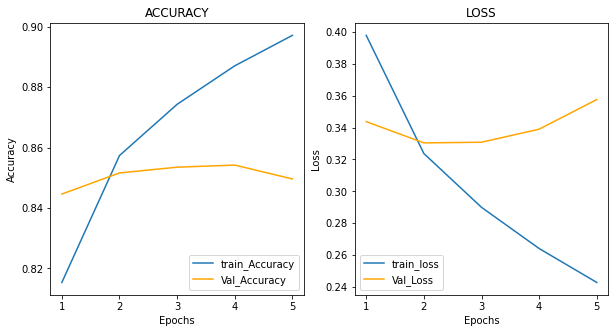

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'orange', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


train_loss는 점점 줄어들고 val_loss는 증가하다가 약간감소하는 부분이 있으나 그 부분이 기존 LSTM보다 더 크게 꺾이는 걸 보니 기존 model보다 큰 편이다. 하지만 이 또한, 결국 val_loss가 증가하는 추세를 보니 과적합이 되었을 수도 있다고 생각이 듭니다.

## 모델3. Bidirectional LSTM with Dropout

### Drop

직관적인 함수의 용어를 사용하면, 가중치 값들이 다른 특성(feature)들 사이에 더 확산되도록 하고, 잠재적으로 가짜 연관들에 더 적게 의존되도록 모델을 학습시킴

In [28]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences = False), input_shape = (49,1)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                5920      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 328       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 166,257
Trainable params: 166,257
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 32s 14ms/step - loss: 0.4575 - accuracy: 0.7748 - val_loss: 0.3469 - val_accuracy: 0.8443
Epoch 2/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.3250 - accuracy: 0.8603 - val_loss: 0.3361 - val_accuracy: 0.8502
Epoch 3/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2878 - accuracy: 0.8770 - val_loss: 0.3323 - val_accuracy: 0.8565
Epoch 4/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2570 - accuracy: 0.8909 - val_loss: 0.3423 - val_accuracy: 0.8543
Epoch 5/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2339 - accuracy: 0.9031 - val_loss: 0.3653 - val_accuracy: 0.8502


In [30]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.6560 - accuracy: 0.5412
[0.6559510827064514, 0.5412454009056091]


In [31]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


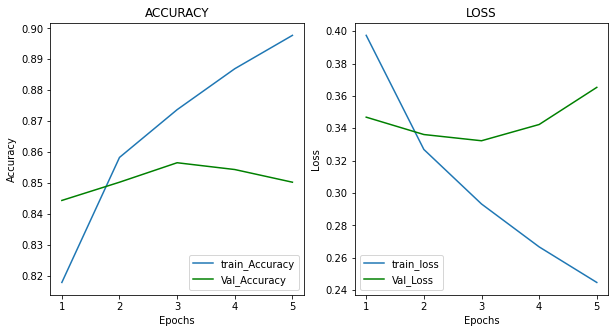

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'green', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'green', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

train_loss는 점점 줄어들고 val_loss는 증가하다가 약간감소하는 부분이 있으나 그 부분이 기존 LSTM보다 더 크게 꺾이는 걸 보니 기존 model보다 굉장히 큰 편이다. 그리고 또 하나의 특징은 dropout를 해서 그런지 accuarcy가 좋았다. 하지만 이 또한, 결국 val_loss가 증가하는 추세를 보니 과적합이 되었을 수도 있다고 생각이 듭니다.

## 모델4. 1-D CNN

: 꼭 RNN이어야 할까라는 LMS를 보고 신기하고 알아보고 싶어서 선택하게 되었습니다.

In [33]:


vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [34]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
266/266 [==============================] - 11s 24ms/step - loss: 0.6327 - accuracy: 0.6246 - val_loss: 0.4921 - val_accuracy: 0.7346
Epoch 2/5
266/266 [==============================] - 2s 7ms/step - loss: 0.4638 - accuracy: 0.7597 - val_loss: 0.4825 - val_accuracy: 0.7413
Epoch 3/5
266/266 [==============================] - 2s 7ms/step - loss: 0.4262 - accuracy: 0.7822 - val_loss: 0.4847 - val_accuracy: 0.7407
Epoch 4/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3981 - accuracy: 0.7990 - val_loss: 0.4979 - val_accuracy: 0.7383
Epoch 5/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3689 - accuracy: 0.8132 - val_loss: 0.5243 - val_accuracy: 0.7337


In [35]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.4554 - accuracy: 0.7939
[0.45543453097343445, 0.7939459085464478]


In [36]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


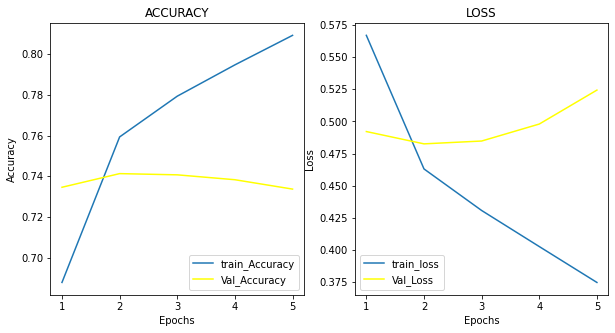

In [39]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'yellow', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'yellow', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

val_loss가 감소하다가 다시 증가하고 이것으로 보아 overfitting라고 생각이 듭니다.

## 임베딩  레이어 (평가문항 2번)

In [40]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


워드 파일에 기록하고 embedding parameter저장

In [41]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [42]:

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('장난아', 0.8566081523895264),
 ('케미', 0.8416340351104736),
 ('기다려', 0.8389480113983154),
 ('숨', 0.8369996547698975),
 ('무용', 0.8330315351486206),
 ('절정', 0.8205424547195435),
 ('결정판', 0.8142094612121582),
 ('검프', 0.8108370304107666),
 ('파라', 0.8102103471755981),
 ('유치원', 0.8092784881591797)]

위의 단어들과의 유사도를 출력하긴 했으나 실제로 "사랑"이라는 단어들과 연관이 크게 있어보이지는 않는다고 생각을 합니다. 아무래도 영어가 아닌 한글이기 때문이라고 조심스럽게 생각해봅니다.

In [1]:
import gensim
gensim.__version__

'3.8.3'

In [46]:
! pip install --upgrade gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Word2Vec Embedding(평가문항3)




In [43]:


from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [50]:
word2vec.wv.most_similar("즐거움")

[('기쁨', 0.7912124395370483),
 ('괴로움', 0.6675163507461548),
 ('매력', 0.6643722057342529),
 ('웃음', 0.6643539667129517),
 ('아름다움', 0.6521420478820801),
 ('행운', 0.6483654975891113),
 ('행복', 0.6396492719650269),
 ('쾌락', 0.635045051574707),
 ('인생', 0.6350153684616089),
 ('욕망', 0.6348717212677002)]

### 생각보다 높진 않지만 그래도 만족한 결과입니다

In [51]:

vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [52]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 44s 20ms/step - loss: 0.4492 - accuracy: 0.7811 - val_loss: 0.3297 - val_accuracy: 0.8543
Epoch 2/5
2128/2128 [==============================] - 41s 19ms/step - loss: 0.2959 - accuracy: 0.8734 - val_loss: 0.3153 - val_accuracy: 0.8638
Epoch 3/5
2128/2128 [==============================] - 41s 19ms/step - loss: 0.2480 - accuracy: 0.8972 - val_loss: 0.3323 - val_accuracy: 0.8611
Epoch 4/5
2128/2128 [==============================] - 41s 19ms/step - loss: 0.2061 - accuracy: 0.9148 - val_loss: 0.3397 - val_accuracy: 0.8599
Epoch 5/5
2128/2128 [==============================] - 41s 19ms/step - loss: 0.1619 - accuracy: 0.9357 - val_loss: 0.3612 - val_accuracy: 0.8600


### accuracy가 86%가 나왔습니다.!!

In [54]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


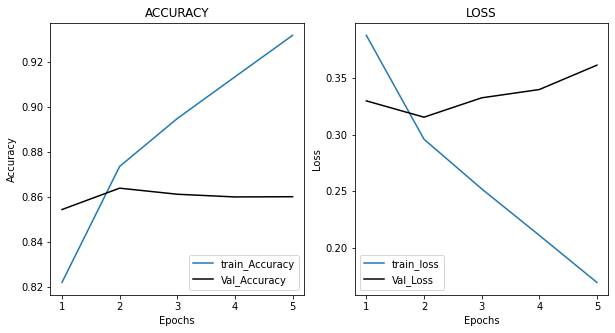

In [55]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'black', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'black', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 프로젝트 회고

NLP는 정말 난해한 것 같습니다. 성능이 좋을 것 같은 모델을 너무 다 넣으면 오히려 과적합이 일어나고 반대로 그렇지 않으면 결과가 나오지 않아서 밀당을 하는 기분입니다. 근데 그것이 NLP의 매력인 것 같아서 또 재미있습니다.

처음에는 어떻게 이끌어 가야할지 몰라서 EX에서 예시로 나온 LSTM, 1-D CNN 그리고 GlobalMaxPolling1D 등이 있었지만 LSTM을 해보다가 구글링을 해보니 점점 발전된 모듈들이 있어서 그것에 대해 파보고 싶어서 배우지 않은
Bidirectional LSTM 과 Dropout를 합한 모듈을 선택했습니다. 물론 이것들의 개념이 완벽하지 않아서 헤즈온 머신러닝 2판을 참고해서 보았습니다.

책에서는 분명히 Bidirectional LSTM이 기존 LSTM보다 성능이 좋다고는 했지만 실제로는 그런 결과가 나오지 않았습니다. 그 이유를 생각해보니 책에서는 하이퍼파라미터 설정이 잘못 되어서 그러한 결과가 나온 것이라고 이야기를 했습니다. 

이번 프로젝트를 통해서 기존 익스는 최적의 하이퍼파라미터를 제시해주셨지만  새로운 모델을 사용하려니 어떤 것이 최적의 하이퍼파라미터인지 잘 몰라서 오래 걸리고 그러다보니 책에서 말하는 결과와 다른 결과가 나와서 유감입니다.

정확도는 처음에는 79%였다가 하이퍼파라미터를 변형해보니 83%까지는 올랐으나 85 이상은 오르지 못했습니다. 허나 익스 시간이 끝나고 저녁시간에 팀원분들이 하신 하이퍼파라미터를 넣어보니 좋은 결과를 얻어서 협업의 중요성을 알았습니다. 

저번에 배운 작사가 인공지능보다 이것이 더 어려웠습니다 그 이유는 아직 한글로 NLP를 구현하는 것이 한계가 있는 것 같습니다.

이번 익스를 진행하면서 가장 어려웠던 것은 마지막에  평가문항을 시작하려고 하는데 ko.bin의 파일이 어디있는지 몰랐고 그걸 찾은 후에도 gensim의 버전이 높아서 실행이 되지 않아서 구글링을 통해서 3.8.3으로 다운을 시켜야 사용을 해야한다는 사실을 알게된 후 적용하니 해결했습니다.


지금까지 익스와 LMS는 사실 어느정도 기반이 잡혀있어서 라이브러리에 대한 깊은 고민과 버전의 생각 그리고 하이퍼파라미터를 조절하는 방식에 대한 고찰을 덜해도 되었으나 이번 익스는 그렇지 않았습니다. 그래서 훗날 지금같은 도메인이 없을 때를 대비하여 많은 공부와 협업 능력이 필요한 것 같습니다.